
## TURKISH
## Proje: Türkçe Metin Sınıflandırma
Bu projede, çeşitli Türkçe metinleri kategorilerine ayıran bir sınıflandırıcı geliştireceğiz. Kullanılacak model `TF-IDF` + `Agglomerative Clusterinng` olacak.

Veri kaynağı: Datas/data.csv
Hedef: 'content' sütunundaki metni kullanarak 'category' sütununu tahmin etmek.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
import re
import string

In [3]:
df = pd.read_csv('Datas/data.csv')
df.head()
df.sample(n=5)

FileNotFoundError: [Errno 2] No such file or directory: 'Datas/data.csv'

## İlk Gözlem
- `content`: metin verisi
- `category`: hedef sınıf (etiket)


In [ ]:
# Boş değerleri sil.
# Küçük harfe çevir.
# Noktalama ve sayıları temizle.
# Stopwords temizliği yap.
# Stemming bu projede opsiyonel

nltk.download('stopwords')
stop_words = set(stopwords.words('turkish'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df.dropna(subset=['content', 'category'], inplace=True)
df['processed_data'] = df['content'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uslan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Axes: xlabel='category'>

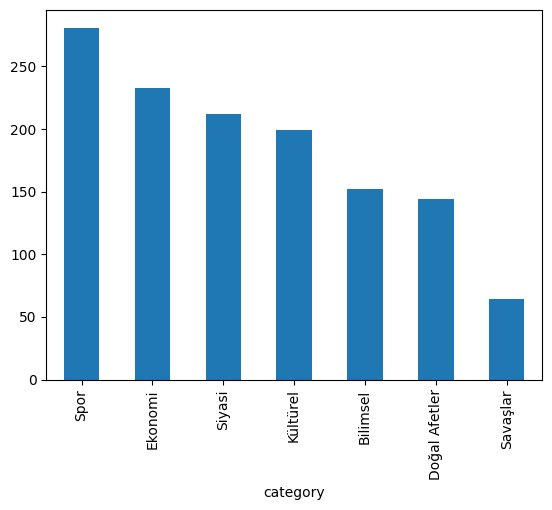

In [ ]:
# Kategori dağılımını grafikle veya tabloda gör
df['category'].value_counts().plot(kind='bar')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)  
#? vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=2000)


X = vectorizer.fit_transform(df['processed_data'])


In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Küme sayısı belirleyelim (örnek: 5)
# normalde 7 kategori var
num_clusters = 7

agglo = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='ward')
clusters = agglo.fit_predict(X.toarray())

df['cluster'] = clusters

df[['category', 'cluster']].head()
df.sample(n=5)


,category,title,content,processed_data,cluster
1157,Spor,2019-20 Kadınlar Süper Ligi (buz hokeyi),"2019-20 Kadınlar Süper Ligi, Kadınlar Süper Li...",kadınlar süper ligi kadınlar süper liginin sez...,3
214,Bilimsel,a,"TP-LINK ARCHER D7AKTA A4 W Archer D7, üst sevi...",tplink archer dakta a w archer d üst seviye bi...,1
1229,Spor,2023 Vehbi Emre & Hamit Kaplan Turnuvası,"2023 Vehbi Emre & Hamit Kaplan Turnuvası, 21-2...",vehbi emre hamit kaplan turnuvası haziran tari...,2
75,Bilimsel,Galip Akay,"Galip Akay, (d. 1945, Şarkışla, Sivas) Türk as...",galip akay d şarkışla sivas türk asıllı i̇ngil...,1
417,Ekonomi,a,"Kazan Belediyesi Zabıta ekipleri, esnaf deneti...",kazan belediyesi zabıta ekipleri esnaf denetim...,1


In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score

# Gerçek kategorileri sayısala dönüştür
le = LabelEncoder()
labels_num = le.fit_transform(df['category'])

# Kümeleme sonuçları (senin clustering sonucu)
clusters = agglo.fit_predict(X.toarray())

cluster_label_map = {}

# Her cluster için en çok bulunan kategori sayısal kodunu bul
for cluster_id in np.unique(clusters):
    mask = (clusters == cluster_id)
    cluster_labels = labels_num[mask]
    if len(cluster_labels) == 0:
        print("Boş küme atlandı")
        continue
    most_common_num = Counter(cluster_labels).most_common(1)[0][0]
    cluster_label_map[cluster_id] = most_common_num  # burada atama yapılmalı

# Sayısal kodları string kategori isimlerine dönüştür
cluster_label_map_str = {cluster_id: le.inverse_transform([num])[0] 
                        for cluster_id, num in cluster_label_map.items()}

# Tahmin edilen sayısal kategoriler (cluster'dan tahmin edilen kategori)
predicted_num_categories = np.array([cluster_label_map[c] for c in clusters])

# Sayısal kategorileri tekrar orijinal string label'a çevir
predicted_categories = le.inverse_transform(predicted_num_categories)

# Gerçek kategoriler
true_categories = df['category'].values

# Doğruluk ölçümü
accuracy = accuracy_score(true_categories, predicted_categories)

print(f"Cluster-label eşleştirilmiş doğruluk: {accuracy:.4f}")

print("Cluster - Gerçek kategori eşleşmeleri:")
for cid, cat in cluster_label_map_str.items():
    print(f"Cluster {cid} -> {cat}")


Cluster-label eşleştirilmiş doğruluk: 0.5307
Cluster - Gerçek kategori eşleşmeleri:
Cluster 0 -> Spor
Cluster 1 -> Ekonomi
Cluster 2 -> Spor
Cluster 3 -> Spor
Cluster 4 -> Kültürel
Cluster 5 -> Doğal Afetler
Cluster 6 -> Siyasi


In [ ]:
import joblib

# Model ve vectorizer'ı kaydet
joblib.dump(agglo, 'Models/agglo_model.joblib')
joblib.dump(vectorizer, 'Models/tfidf_vectorizer.joblib')

# Daha sonra tekrar yüklemek için
agglo_loaded = joblib.load('Models/agglo_model.joblib')
vectorizer_loaded = joblib.load('Models/tfidf_vectorizer.joblib')


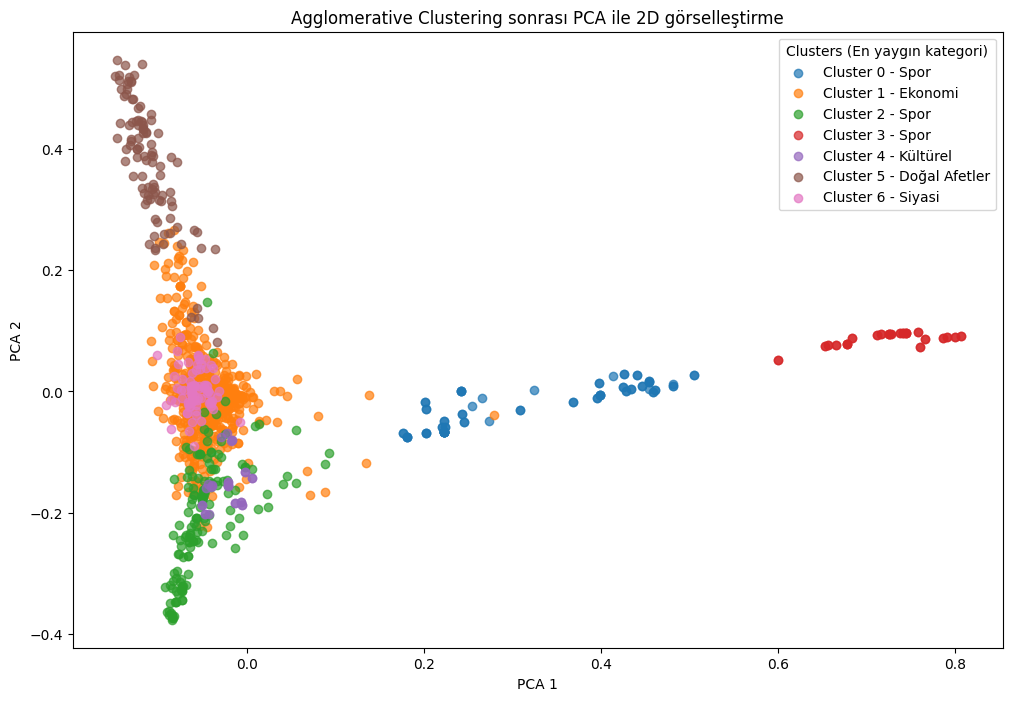

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# PCA ile 2 boyuta indir
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

num_clusters = len(np.unique(clusters))
colors = plt.cm.tab10.colors

plt.figure(figsize=(12,8))

for cluster_id in range(num_clusters):
    idx = np.where(clusters == cluster_id)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], 
                color=colors[cluster_id % 10], 
                label=f"Cluster {cluster_id} - {cluster_label_map_str[cluster_id]}", 
                alpha=0.7)


plt.title('Agglomerative Clustering sonrası PCA ile 2D görselleştirme')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title="Clusters (En yaygın kategori)", loc='upper right')
plt.show()


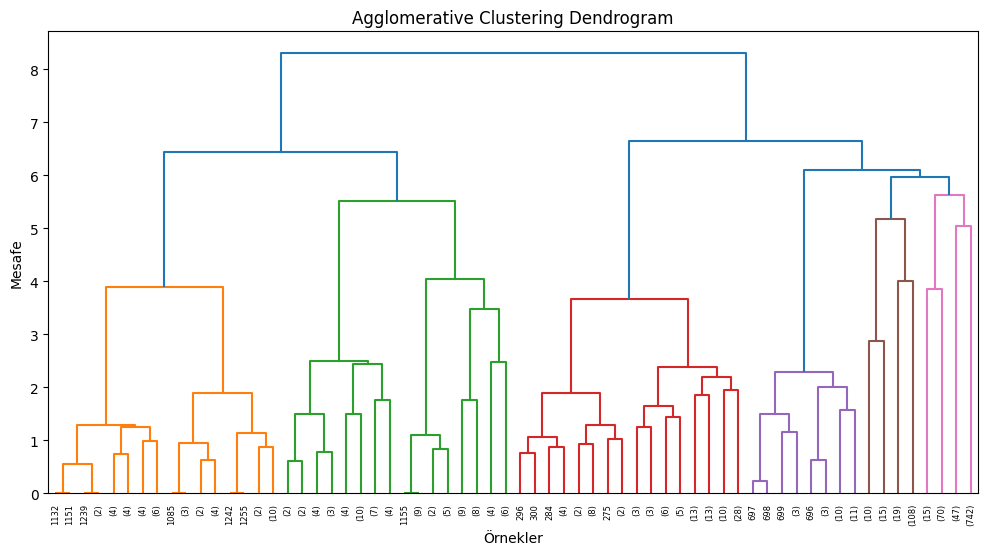

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X.toarray(), method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5)  # sadece ilk 5 seviyeyi gösterir
plt.title('Agglomerative Clustering Dendrogram')
plt.xlabel('Örnekler')
plt.ylabel('Mesafe')
plt.show()


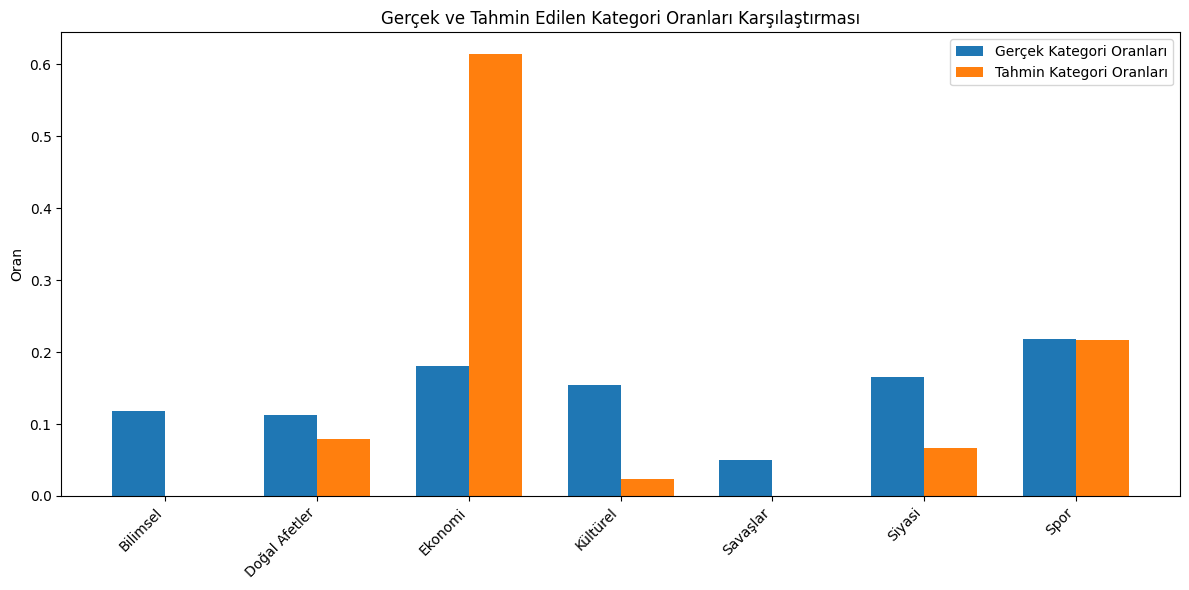

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Gerçek kategori oranları
true_counts = df['category'].value_counts(normalize=True).sort_index()

# Tahmin edilen kategori oranları
predicted_counts = pd.Series(predicted_categories).value_counts(normalize=True).sort_index()

# Tüm kategoriler (gerçek ve tahmin edilenlerde birleşik)
all_categories = sorted(set(true_counts.index).union(predicted_counts.index))

true_vals = [true_counts.get(cat, 0) for cat in all_categories]
predicted_vals = [predicted_counts.get(cat, 0) for cat in all_categories]

x = np.arange(len(all_categories))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, true_vals, width, label='Gerçek Kategori Oranları')
rects2 = ax.bar(x + width/2, predicted_vals, width, label='Tahmin Kategori Oranları')

ax.set_ylabel('Oran')
ax.set_title('Gerçek ve Tahmin Edilen Kategori Oranları Karşılaştırması')
ax.set_xticks(x)
ax.set_xticklabels(all_categories, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()
